In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from utils import *
from scipy.stats import mannwhitneyu
from matplotlib.ticker import ScalarFormatter
from statannotations.Annotator import Annotator
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

# font settings
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = 'Arial'

# discrete colormap for quantiles
cmap = plt.get_cmap('coolwarm', 19)
colors = cmap(np.linspace(0.05, 0.95, 19))

## Simulated dataset

The maturation probabilities for *T. japonicus* first-time spawners at each spawning age are generated using the following equation:

$$p=\frac{1}{1+e^{-\eta[W_n-\frac{1}{k}(W_{min}+W_{max})]}}$$

In [2]:
# define simulation parameters
age_range = [1, 2, 3, 4]  # Am
num_samples_per_age = [900, 600, 400, 200]  # N
weight_ranges = {1: (250, 600), 2: (300, 750), 3: (300, 900), 4: (320, 1000)}  # Wmin and Wmax
noise_std = 50  # sigma
Eta = {1: 0.02, 2: 0.02, 3: 0.04, 4: 0.04}  # eta
K = {1: 2, 2: 2, 3: 2.8, 4: 3.5}  # k

# generate data for each age group
np.random.seed(42)
data = []
for idx, age in enumerate(age_range):
    eta = Eta[age]
    k = K[age]
    weight_min, weight_max = weight_ranges[age]
    weight_ = np.random.uniform(weight_min, weight_max, num_samples_per_age[idx])
    noise = np.random.normal(0, noise_std, num_samples_per_age[idx])
    weight = weight_ + noise

    # maturation probability
    prob = 1 / (1 + np.exp(-eta * (weight - (weight_min + weight_max) / k)))
    status = np.random.binomial(1, prob)
    
    for w, s in zip(weight, status):
        data.append([age, w, s])

# save to CSV file
df = pd.DataFrame(data, columns=['newage', 'total_w', 'mat'])
df.to_csv(f"./Data/data_simulated.csv", index=False, sep=',')

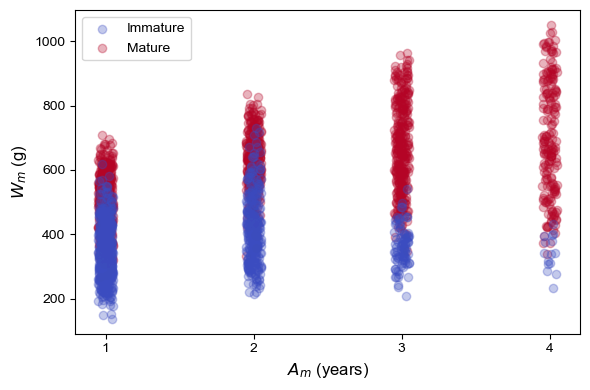

In [3]:
# scatter plots for simulated individuals
plt.figure(figsize=(6, 4))
for i, l in enumerate(['Immature', 'Mature']):
    sns.regplot(x='newage', y='total_w', data=df[df.mat==i], color=colors[i*18], fit_reg=False, x_jitter=0.05,
                label=l, scatter_kws={'alpha': 0.3, 'zorder': -(i+1)*10})
plt.xlabel(r'$A_{m}$ (years)', fontsize=12)
plt.xticks([1, 2, 3, 4], ['1', '2', '3', '4'])
plt.ylabel(r'$W_{m}$ (g)', fontsize=12)
plt.legend(fontsize=10)

# Save figures
plt.tight_layout()
plt.savefig("./Figs/Figure_S1.pdf")
plt.savefig("./Figs/Figure_S1.png", format="png", dpi=600, bbox_inches="tight")

## Age-specific logistic MM and deep BQMM for estimating PMRNs and QMRNs

In [4]:
age_list = np.sort(df.newage.unique())
PMRNs_list = []
QMRNs_list = []
attribute_list = []
interpolated_list = []
intersections_list = []
Logis_model_list = []

for idx, age in enumerate(age_list):
    df_age = df[df.newage==age]
    x = df_age.total_w
    y = df_age.mat
    x_values = np.linspace(df_age.total_w.min(), df_age.total_w.max(), 100)
    
    try:
        model = LogisticRegression(max_iter=100000)
        Logis_model_list.append(model)
        model.fit(x.to_numpy().reshape(-1, 1), y)
        probabilities = model.predict_proba(x_values.reshape(-1, 1))[:, 1]

        target_probabilities = np.linspace(0.05, 0.95, 19)
        x_values_for_target_probabilities = [age]
        for probability in target_probabilities:
            x_value_for_target_probability = (np.log(probability / (1 - probability)) - model.intercept_) / model.coef_.flatten()
            x_values_for_target_probabilities.append(x_value_for_target_probability[0])
        PMRNs_list.append(x_values_for_target_probabilities)
       
        df_age.to_csv(f"./Data/data_simulated_Am{age}.csv", index=False, sep=',')
        attribute_array, outputs = BQR(f"./Data/data_simulated_Am{age}.csv",
                                       batch_is=64,
                                       x_cols=[1],
                                       y_col=2,
                                       attribute_index=0,
                                       attribute_name="newage",
                                       latent_name="Maturity",
                                       total_epochs=20,
                                       ndim=1)
        attribute_list.append(attribute_array)
        
        interpolated = []
        available_tau = np.linspace(0.1, 0.9, 9)
        new_tau = np.linspace(0.05, 0.95, 19)
        for i in new_tau:
            interpolated.append(smoothed_quantile(i, available_tau, outputs))
        interpolated_list.append(interpolated)
        
        intersections_ = []
        for i in interpolated[::-1]:
            intersections = calculate_intersections(attribute_array, i)
            intersections_.append(intersections)
        intersections_list.append(intersections_)

    except ValueError as e:
        print("Skipping age ", + age)
        pass

QMRNs_list = np.matrix(intersections_list)

Torch Device: cpu
[5/20] Test Acc Q : 0.777778  
[10/20] Test Acc Q : 0.800000  
[15/20] Test Acc Q : 0.788889  
[20/20] Test Acc Q : 0.800000  
Torch Device: cpu
[5/20] Test Acc Q : 0.816667  
[10/20] Test Acc Q : 0.841667  
[15/20] Test Acc Q : 0.833333  
[20/20] Test Acc Q : 0.825000  
Torch Device: cpu
[5/20] Test Acc Q : 0.962500  
[10/20] Test Acc Q : 0.962500  
[15/20] Test Acc Q : 0.975000  
[20/20] Test Acc Q : 0.962500  
Torch Device: cpu
[5/20] Test Acc Q : 0.925000  
[10/20] Test Acc Q : 0.925000  
[15/20] Test Acc Q : 0.975000  
[20/20] Test Acc Q : 0.975000  


## One-dimensional PMRNs vs. QMRNs

- with weight as predictor, given age
- by default, QMRNs are calculated using interpolation

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_PMRNs vs. 1_QMRNs: Mann-Whitney-Wilcoxon test two-sided, P_val:8.609e-01 U_stat=1.870e+02
2_PMRNs vs. 2_QMRNs: Mann-Whitney-Wilcoxon test two-sided, P_val:7.261e-01 U_stat=1.680e+02
3_PMRNs vs. 3_QMRNs: Mann-Whitney-Wilcoxon test two-sided, P_val:8.381e-01 U_stat=1.730e+02
4_PMRNs vs. 4_QMRNs: Mann-Whitney-Wilcoxon test two-sided, P_val:5.398e-01 U_stat=2.020e+02


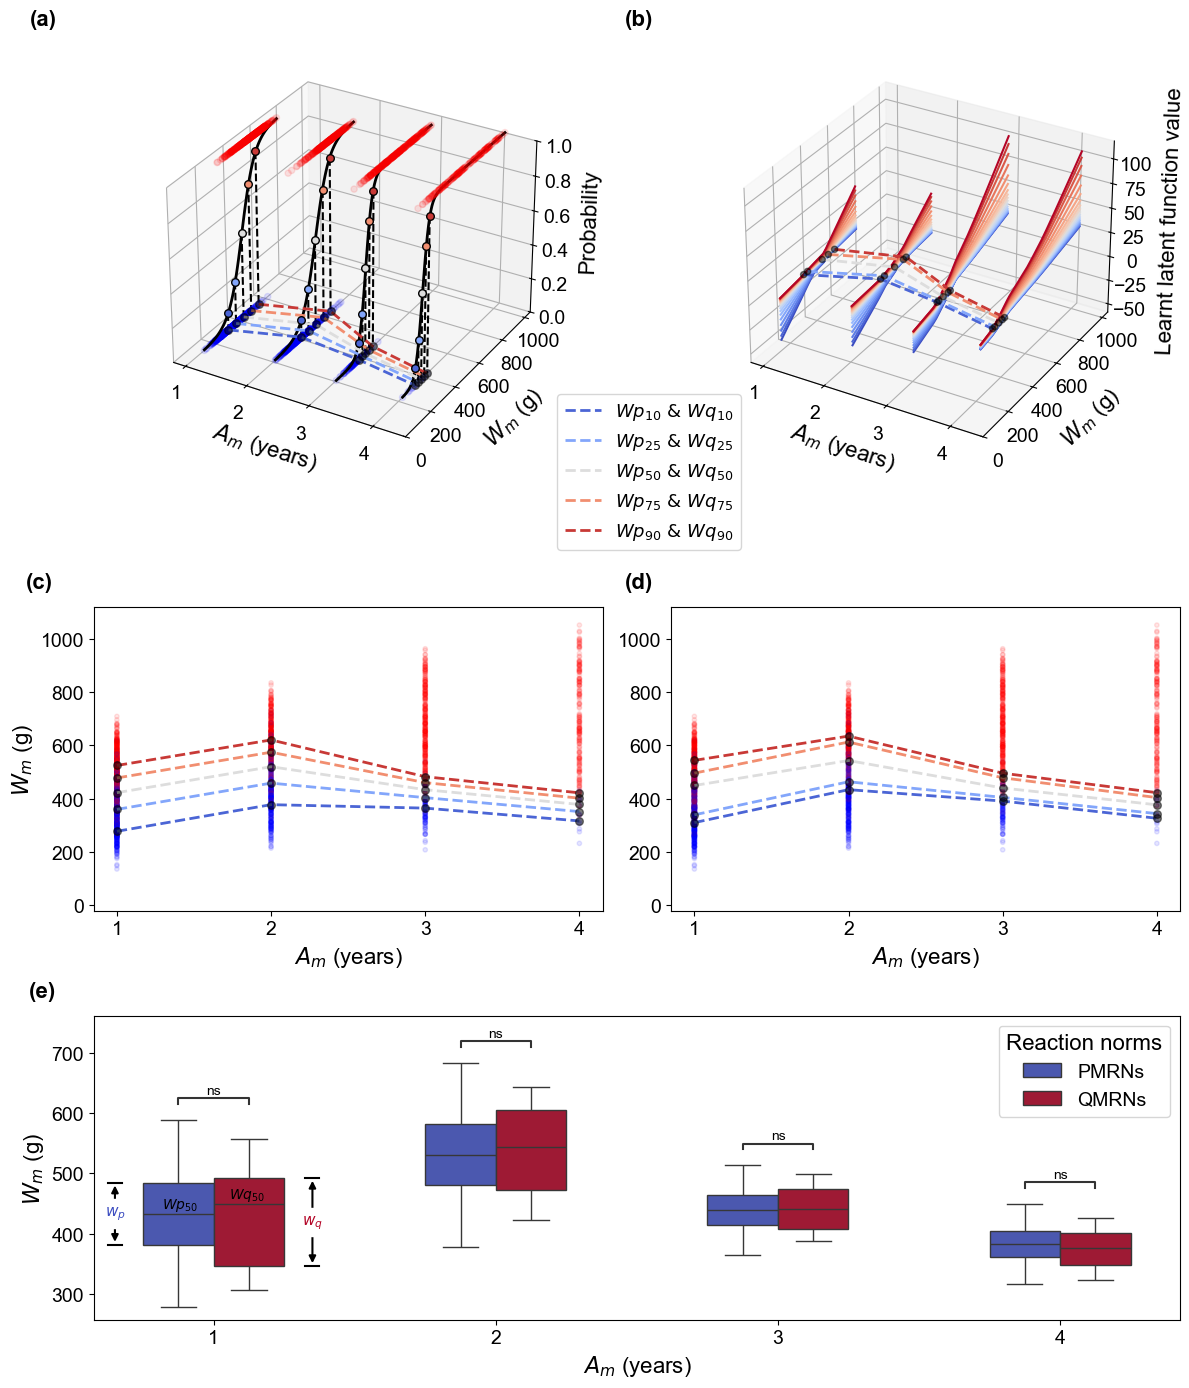

In [14]:
# Create figure with custom size and grid layout
fig = plt.figure(figsize=(12, 14))
gs = gridspec.GridSpec(3, 2, height_ratios=[3.2, 2, 2])
ax1 = fig.add_subplot(gs[0, 0], projection='3d',computed_zorder=False)
ax2 = fig.add_subplot(gs[0, 1], projection='3d',computed_zorder=False)
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1], sharex=ax3, sharey=ax3)
ax5 = fig.add_subplot(gs[2, :])

# PMRN (Probabilistic Maturation Reaction Norms) Visualization
Lp_list = []
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]  # also probabilities
q_vis = [1, 4, 9, 14, 17]
cmap = plt.get_cmap('coolwarm', 19)
colors = cmap(np.linspace(0.05, 0.95, 19))

for i in range(1, 5):
    # Age-specific data
    age_data = df[df['newage'] == i]
    
    # Scatter plot for immature (mat=0) and mature (mat=1) fish
    ax1.scatter(np.ones(len(age_data[age_data['mat'] == 0])) * i, age_data[age_data['mat'] == 0]['total_w'],
               age_data[age_data['mat'] == 0]['mat'], c='blue', alpha=0.1, zorder=4, label=f'Age {i} - mat 0' if i == 1 else "")
    ax1.scatter(np.ones(len(age_data[age_data['mat'] == 1])) * i, age_data[age_data['mat'] == 1]['total_w'],
               age_data[age_data['mat'] == 1]['mat'], c='red', alpha=0.1, zorder=6, label=f'Age {i} - mat 1' if i == 1 else "")

    # Create size range for current age
    size_range = np.linspace(age_data.total_w.min(), age_data.total_w.max(), 100)
    X_age = np.ones(100) * i
    # Predict maturation probability using logistic model
    prob = Logis_model_list[i-1].predict_proba(size_range.reshape(-1, 1))[:, 1]
    # Plot probability curve
    ax1.plot(X_age, size_range, prob, color='k', linewidth=2, zorder=5)

    # Calculate and plot probabilities
    Lp = [i]
    for j, q in enumerate(quantiles):
        # Find size at which probability equals the probability
        quantile_size = size_range[np.argmin(np.abs(prob - q))]
        Lp.append(quantile_size)
        # Plot 3D point at quantile
        ax1.scatter(i, quantile_size, q, color=colors[q_vis[j]], s=30, edgecolor='k', zorder=6,
                   label=f'{q} Quantile Age {i}' if i == 1 else "")
        # Plot projection on bottom plane
        ax1.scatter(i, quantile_size, 0, color='k', s=30, alpha=0.5, zorder=10)
    Lp_list.append(Lp)

# Connect probabilities across ages with dashed lines
for j, q in enumerate(quantiles):
    x_vals = []
    y_vals = []
    for i in range(1, 5):
        age_data = df[df['newage'] == i]
        size_range = np.linspace(age_data.total_w.min(), age_data.total_w.max(), 100)
        prob = Logis_model_list[i-1].predict_proba(size_range.reshape(-1, 1))[:, 1]
        quantile_size = size_range[np.argmin(np.abs(prob - q))]
        x_vals.append(i)
        y_vals.append(quantile_size)
        # Draw vertical dashed line from probability to bottom plane
        ax1.plot([i, i], [quantile_size, quantile_size], [q, 0], color='black', linestyle='--', zorder=2) # 绘制黑色虚线
    # Connect probabilities across ages on bottom plane
    ax1.plot(x_vals, y_vals, [0]*len(x_vals), color=colors[q_vis[j]], linestyle='--', linewidth=2, zorder=5)

# Axis limits and labels for PMRN plot
ax1.set_xlim(0.8, 4.5)
ax1.set_ylim(0, 1050)
ax1.set_zlim(0, 1)
ax1.set_xlabel(r'$A_{m}$ (years)', fontsize=16, labelpad=8)
ax1.set_ylabel(r'$W_{m}$ (g)', fontsize=16, labelpad=13)
ax1.set_zlabel('Probability', fontsize=16, labelpad=8)
ax1.set_xticks([1, 2, 3, 4])
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(axis='z', labelsize=14)
ax1.view_init(elev=30, azim=-60)  # 3D view angle
ax1.set_box_aspect(None, zoom=0.85)  # Adjust 3D box aspect ratio

# QMRN (Quantile Maturation Reaction Norms) Visualization
Lq_list = []
age_list = [1,2,3,4]
label_vis = ["q: 0.1", "q: 0.25", "q: 0.5", "q: 0.75", "q: 0.9"]

# Plot QMRN curves for each age and quantile
for idx, age in enumerate(age_list):
    for i, tau in enumerate(new_tau):
        ax2.plot(np.repeat(age, len(attribute_list[idx])), attribute_list[idx], interpolated_list[idx][i],
                 color=colors[i], label=f"q: {tau:.2f}", zorder=0)   

# Plot and store QMRNs
for qdx, q in enumerate(q_vis):
    Lq_list.append(QMRNs_list[:,q].tolist())
    # Plot connection lines on bottom plane
    ax2.plot(age_list, QMRNs_list[:,q].flatten().tolist(), np.repeat(0, len(age_list)), color=colors[q], linewidth=2,
            linestyle='--', zorder=0)
    # Plot points on bottom plane
    ax2.scatter(age_list, QMRNs_list[:,q].flatten().tolist(), np.repeat(0, len(age_list)), s=20, color='k', alpha=0.5, zorder=10)

# Axis limits and labels for QMRN plot
ax2.set_xlim(0.8, 4.5)
ax2.set_ylim(0, 1050)
ax2.set_xlabel(r'$A_{m}$ (years)', fontsize=16, labelpad=8)
ax2.set_ylabel(r'$W_{m}$ (g)', fontsize=16, labelpad=13)
ax2.set_zlabel('Learnt latent function value', fontsize=16, labelpad=10)
ax2.set_xticks([1, 2, 3, 4])
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.tick_params(axis='z', labelsize=14)
ax2.view_init(elev=30, azim=-60)  # 3D view angle
ax2.set_box_aspect(None, zoom=0.85)  # Adjust 3D box aspect ratio

#######################################################################################################

# PMRNs & QMRNs comparison plots
Q5_list = [1, 4, 9, 14, 17]  # Selected [0.1, 0.25, 0.5, 0.75 0.9] quantile indices
Label5_list = [r'$Wp_{10} \ & \ Wq_{10}$', r'$Wp_{25} \ & \ Wq_{25}$', r'$Wp_{50} \ & \ Wq_{50}$',
               r'$Wp_{75} \ & \ Wq_{75}$', r'$Wp_{90} \ & \ Wq_{90}$']

# Plot PMRN and QMRN values for selected quantiles
for idq, q in enumerate(Q5_list):
    # Plot PMRNs (left plot)
    ax3.plot(np.matrix(PMRNs_list)[:,0], np.matrix(PMRNs_list)[:,q], color=colors[q], linewidth=2,
             linestyle='--', label=Label5_list[idq])
    ax3.scatter(np.array(PMRNs_list)[:,0], np.array(PMRNs_list)[:,q], s=30, color='k', zorder=10, alpha=0.5)
    
    # Plot QMRNs (right plot)
    ax4.plot(np.linspace(1, 4, 4), QMRNs_list[:,q], color=colors[q], linewidth=2, linestyle='--')
    ax4.scatter(np.linspace(1, 4, 4), np.array(QMRNs_list[:,q]), s=30, color='k', zorder=10, alpha=0.5)

# Add background age-weight scatter points for context
ax3.scatter(df.newage, df.total_w, color=['red' if mat == 1 else 'blue' for mat in df['mat']], alpha=0.1, s=10)
ax3.yaxis.get_offset_text().set_fontsize(12) 
# Set labels and ticks
ax3.set_xlabel(r'$A_{m}$ (years)', fontsize=16)
ax3.set_xticks([1, 2, 3, 4])
ax3.set_ylim(-20, 1120)
ax3.set_yticks([0, 200, 400, 600, 800, 1000])
ax3.set_ylabel(r'$W_{m}$ (g)', fontsize=16)
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)

# Add background age-weight scatter points for context
ax4.scatter(df.newage, df.total_w, color=['red' if mat == 1 else 'blue' for mat in df['mat']], alpha=0.1, s=10)
ax4.yaxis.get_offset_text().set_fontsize(12)
ax4.set_yticks([0, 200, 400, 600, 800, 1000])
# Set labels and ticks
ax4.set_xlabel(r'$A_{m}$ (years)', fontsize=16)
ax4.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='y', labelsize=14)

# Add legend for Probabilistic & quantile lines
handles1, labels1 = ax3.get_legend_handles_labels()
fig.legend(handles1, labels1, loc='upper center', bbox_to_anchor=(0.545, 0.72), ncol=1, fontsize=13)

#######################################################################################################

## Mann-Whitney U test for comparing PMRNs and QMRNs
results = []

# Mann-Whitney U test for each age group
for i in range(4):
    p = np.ravel(np.matrix(PMRNs_list)[i, 1:])  # PMRNs
    q = np.ravel(QMRNs_list[i, :])   # QMRNs
    u_statistic, p_value = mannwhitneyu(p, q)  # Mann-Whitney U test
    results.append({'Age': i+1, 'U_statistic': u_statistic, 'P_value': p_value})

results_df = pd.DataFrame(results)
data = []

for i in range(4):
    for value in np.ravel(np.matrix(PMRNs_list)[i, 1:]):
        data.append({'Age': i+1, 'Group': 'PMRNs', 'Value': value})
    for value in np.ravel(QMRNs_list[i, :]):
        data.append({'Age': i+1, 'Group': 'QMRNs', 'Value': value})

data_df = pd.DataFrame(data)
# Define comparisons for statistical annotation
significanceComparisons = [((1,'PMRNs'), (1,'QMRNs')), ((2,'PMRNs'), (2,'QMRNs')),
                           ((3,'PMRNs'), (3,'QMRNs')), ((4,'PMRNs'), (4,'QMRNs'))]
# Figure arguments for boxplot
fig_args = {'x': 'Age',
            'y': 'Value',
            'hue': 'Group',
            'width': 0.5,
            'data': data_df,
            'order': [1, 2, 3, 4],
            'hue_order': ['PMRNs','QMRNs'],
            'dodge': True}

# Configure statistical annotation
configuration = {'test':'Mann-Whitney', 'comparisons_correction': None, 'text_format':'star'}
custom_palette = {'PMRNs': colors[0], 'QMRNs': colors[-1]}

sns.boxplot(ax=ax5, **fig_args, palette=custom_palette)
# Add statistical annotations
annotator = Annotator(ax=ax5, pairs=significanceComparisons, **fig_args, plot='boxplot')
annotator.configure(**configuration).apply_test().annotate()

# Add IQR annotations for 1 age group
for i in range(4):
    if i==0:
        Q1_PMRN = np.percentile(np.ravel(np.matrix(PMRNs_list)[i, 1:]), 25)
        Q2_PMRN = np.percentile(np.ravel(np.matrix(PMRNs_list)[i, 1:]), 50)
        Q3_PMRN = np.percentile(np.ravel(np.matrix(PMRNs_list)[i, 1:]), 75)
        Q1_QMRN = np.percentile(np.ravel(QMRNs_list[i, :]), 25)
        Q2_QMRN = np.percentile(np.ravel(QMRNs_list[i, :]), 50)
        Q3_QMRN = np.percentile(np.ravel(QMRNs_list[i, :]), 75)
    
        add_iqr_annotation(ax5, Q1_PMRN, Q2_PMRN, Q3_PMRN, w_position=i-0.35, W_position=i-0.12, width=0.05, color=colors[0],
                           label_w=r'$w_{p}$', label_W=r'$Wp_{50}$')
        add_iqr_annotation(ax5, Q1_QMRN, Q2_QMRN, Q3_QMRN, w_position=i+0.35, W_position=i+0.12, width=0.05, color=colors[-1],
                           label_w=r'$w_{q}$', label_W=r'$Wq_{50}$')

# Set labels and ticks for boxplot
ax5.set_xlabel(r'$A_{m}$ (years)', fontsize=16)
ax5.set_ylabel(r'$W_{m}$ (g)', fontsize=16)
ax5.tick_params(axis='x', labelsize=14)
ax5.tick_params(axis='y', labelsize=14)

# Add legend
legend = ax5.legend(fontsize=14, title='Reaction norms')
legend.get_title().set_fontsize(16)

#######################################################################################################

# Add subplot labels
Alphbeta = ['a', 'b', 'c', 'd', 'e']
Label_loc = [(-0.1, 0.98), (-0.06, 0.98), (-0.08, 1.06), (-0.035, 1.06), (-0.035, 1.06)]
for i, ax_ in enumerate([ax1, ax2, ax3, ax4, ax5]):
    if i < 2:
        ax_.text2D(Label_loc[i][0], Label_loc[i][1], '('+ Alphbeta[i]+')', transform=ax_.transAxes, ha='right',
                   fontsize=16, fontweight='bold')
    else:
        ax_.text(Label_loc[i][0], Label_loc[i][1], '('+ Alphbeta[i]+')', transform=ax_.transAxes, ha='right',
                 fontsize=16, fontweight='bold')

# Save figures
plt.tight_layout()
plt.savefig("./Figs/Figure_2.pdf")
plt.savefig("./Figs/Figure_2.png", format="png", dpi=600, bbox_inches="tight")
plt.savefig("./Figs/Figure_2_300dpi.png", format="png", dpi=300, bbox_inches="tight")

In [6]:
# age-specific maturation curves (probabilistic)
Lp_df = pd.DataFrame(Lp_list, columns=['Age_m', 'p10', 'p25', 'p50', 'p75', 'p90'])
Lp_df

,Age_m,p10,p25,p50,p75,p90
0,1,315.737942,373.587584,431.437227,489.286869,547.136511
1,2,415.245421,471.620801,527.996181,590.635493,647.010873
2,3,383.755069,414.232846,437.091179,467.568956,498.046733
3,4,331.943957,356.761279,381.578600,406.395922,431.213243


In [7]:
# age-specific maturation curves (quantile)
Lq_df = pd.concat((pd.DataFrame([1,2,3,4]), pd.DataFrame(QMRNs_list[:,[1,4,9,14,17]])) ,axis=1)
Lq_df.columns = ['Age_m', 'q10', 'q25', 'q50', 'q75', 'q90']
Lq_df 

,Age_m,q10,q25,q50,q75,q90
0,1,310.563997,339.730940,449.823190,496.175756,544.086342
1,2,434.180441,463.812030,543.448628,612.844289,635.151587
2,3,391.374048,405.134985,440.397521,478.705271,495.906761
3,4,326.856000,344.327197,377.285060,404.464125,422.884657


In [8]:
# PMRN width
Lp_df.p75-Lp_df.p25

0    115.699284
1    119.014692
2     53.336110
3     49.634643
dtype: float64

In [9]:
# QMRN width
Lq_df.q75-Lq_df.q25

0    156.444815
1    149.032259
2     73.570287
3     60.136928
dtype: float64

## Non-interpolation QMRN

In [10]:
age_list = np.sort(df.newage.unique())
QMRNs_005_list = []  ## The “005” in the variable name indicates that no interpolation was performed
attribute_005_list = []
intersections_005_list = []

for idx, age in enumerate(age_list):
    df_age = df[df.newage==age]
    x = df_age.total_w
    y = df_age.mat
    
    try:    
        df_age.to_csv(f"./Data/data_simulated_Am{age}.csv", index=False, sep=',')
        attribute_array_005, outputs_005 = BQR(f"./Data/data_simulated_Am{age}.csv",
                                               batch_is=64,
                                               x_cols=[1],
                                               y_col=2,
                                               attribute_index=0,
                                               attribute_name="newage",
                                               latent_name="Maturity",
                                               total_epochs=40,
                                               ndim=1,
                                               q=0.05)  # avoid interpolation when W75-W25
        attribute_005_list.append(attribute_array_005)
        
        
        intersections_005_ = []
        for i in outputs_005[::-1]:
            intersections = calculate_intersections(attribute_array_005, i)
            intersections_005_.append(intersections)
        intersections_005_list.append(intersections_005_)

    except ValueError as e:
        print("Skipping age ", + age)
        pass

QMRNs_005_list = np.matrix(intersections_005_list)

Torch Device: cpu
[5/40] Test Acc Q : 0.788889  
[10/40] Test Acc Q : 0.800000  
[15/40] Test Acc Q : 0.794444  
[20/40] Test Acc Q : 0.805556  
[25/40] Test Acc Q : 0.800000  
[30/40] Test Acc Q : 0.805556  
[35/40] Test Acc Q : 0.794444  
[40/40] Test Acc Q : 0.794444  
Torch Device: cpu
[5/40] Test Acc Q : 0.816667  
[10/40] Test Acc Q : 0.833333  
[15/40] Test Acc Q : 0.833333  
[20/40] Test Acc Q : 0.833333  
[25/40] Test Acc Q : 0.833333  
[30/40] Test Acc Q : 0.841667  
[35/40] Test Acc Q : 0.841667  
[40/40] Test Acc Q : 0.833333  
Torch Device: cpu
[5/40] Test Acc Q : 0.962500  
[10/40] Test Acc Q : 0.975000  
[15/40] Test Acc Q : 0.962500  
[20/40] Test Acc Q : 0.975000  
[25/40] Test Acc Q : 0.962500  
[30/40] Test Acc Q : 0.962500  
[35/40] Test Acc Q : 0.962500  
[40/40] Test Acc Q : 0.962500  
Torch Device: cpu
[5/40] Test Acc Q : 0.925000  
[10/40] Test Acc Q : 0.925000  
[15/40] Test Acc Q : 0.925000  
[20/40] Test Acc Q : 0.925000  
[25/40] Test Acc Q : 0.975000  
[30/

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_Non-interpolation vs. 1_Interpolation: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.810e+02
2_Non-interpolation vs. 2_Interpolation: Mann-Whitney-Wilcoxon test two-sided, P_val:7.962e-01 U_stat=1.620e+02
3_Non-interpolation vs. 3_Interpolation: Mann-Whitney-Wilcoxon test two-sided, P_val:6.614e-01 U_stat=1.650e+02
4_Non-interpolation vs. 4_Interpolation: Mann-Whitney-Wilcoxon test two-sided, P_val:8.434e-01 U_stat=1.640e+02


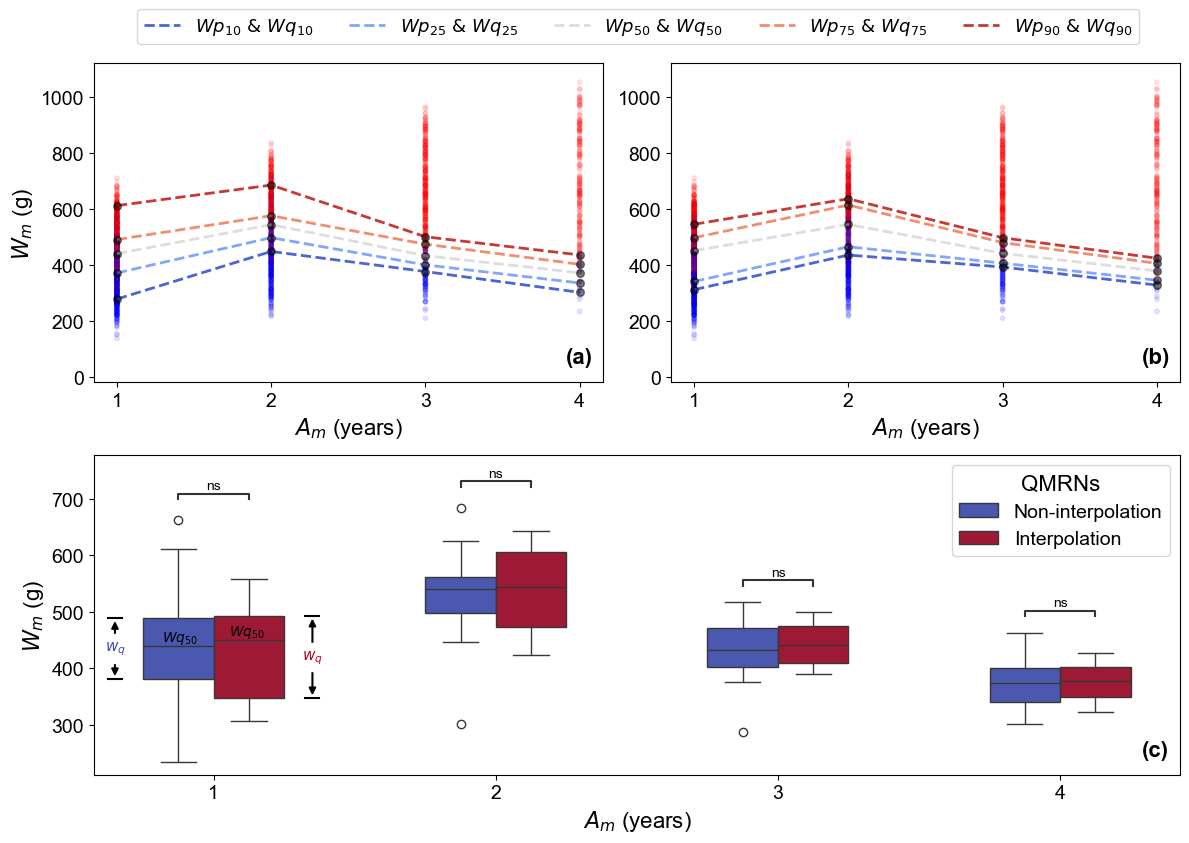

In [13]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[1, :])

# Non-interpolation QMRN & QMRNs (defaute Interpolation QMRNs) comparison plots
Q5_list = [1, 4, 9, 14, 17]  # Selected [0.1, 0.25, 0.5, 0.75, 0.9] quantile indices
Label5_list = [r'$Wp_{10} \ & \ Wq_{10}$', r'$Wp_{25} \ & \ Wq_{25}$', r'$Wp_{50} \ & \ Wq_{50}$',
               r'$Wp_{75} \ & \ Wq_{75}$', r'$Wp_{90} \ & \ Wq_{90}$']

for idq, q in enumerate(Q5_list):
    # --- Non-interpolation QMRNs (left plot, ax1) ---
    ax1.plot(np.linspace(1, 4, 4), np.matrix(QMRNs_005_list)[:, q], color=colors[q], linewidth=2, linestyle='--', label=Label5_list[idq])
    ax1.scatter(np.linspace(1, 4, 4), np.array(QMRNs_005_list)[:, q], s=30, color='k', zorder=10, alpha=0.5)

    # --- QMRNs (right plot, ax2) ---
    ax2.plot(np.linspace(1, 4, 4), QMRNs_list[:, q], color=colors[q], linewidth=2, linestyle='--')
    ax2.scatter(np.linspace(1, 4, 4), np.array(QMRNs_list[:, q]), s=30, color='k', zorder=10, alpha=0.5)

# --- Background scatter plot (Non-interpolation QMRNs) ---
ax1.scatter(df.newage, df.total_w, color=['red' if mat == 1 else 'blue' for mat in df['mat']], alpha=0.1, s=10)
ax1.yaxis.get_offset_text().set_fontsize(12)
ax1.set_xlabel(r'$A_{m}$ (years)', fontsize=16)
ax1.set_xticks([1, 2, 3, 4])
ax1.set_ylim(-20, 1120)
ax1.set_yticks([0, 200, 400, 600, 800, 1000])
ax1.set_ylabel(r'$W_{m}$ (g)', fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

# --- Background scatter plot (QMRNs) ---
ax2.scatter(df.newage, df.total_w, color=['red' if mat == 1 else 'blue' for mat in df['mat']], alpha=0.1, s=10)
ax2.yaxis.get_offset_text().set_fontsize(12)
ax2.set_yticks([0, 200, 400, 600, 800, 1000])
ax2.set_xlabel(r'$A_{m}$ (years)', fontsize=16)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)

# --- Add legend ---
handles1, labels1 = ax1.get_legend_handles_labels()
fig.legend(handles1, labels1, loc='upper center', bbox_to_anchor=(0.536, 1.06), ncol=5, fontsize=13)

#######################################################################################################

## Mann-Whitney U test for comparing Non-interpolation QMRNs and QMRNs
results = []

# Mann-Whitney U test for each age group
for i in range(4):
    q_005 = np.ravel(QMRNs_list[i, :])   # Non-interpolation QMRNs
    q = np.ravel(QMRNs_list[i, :])   # QMRNs
    u_statistic, p_value = mannwhitneyu(q_005, q)  # Mann-Whitney U test
    results.append({'Age': i+1, 'U_statistic': u_statistic, 'P_value': p_value})

results_df = pd.DataFrame(results)
data = []

for i in range(4):
    for value in np.ravel(QMRNs_005_list[i, :]):
        data.append({'Age': i+1, 'Group': 'Non-interpolation', 'Value': value})
    for value in np.ravel(QMRNs_list[i, :]):
        data.append({'Age': i+1, 'Group': 'Interpolation', 'Value': value})

data_df = pd.DataFrame(data)
# Define comparisons for statistical annotation
significanceComparisons = [((1,'Non-interpolation'), (1,'Interpolation')), ((2,'Non-interpolation'), (2,'Interpolation')),
                           ((3,'Non-interpolation'), (3,'Interpolation')), ((4,'Non-interpolation'), (4,'Interpolation'))]
# Figure arguments for boxplot
fig_args = {'x': 'Age',
            'y': 'Value',
            'hue': 'Group',
            'width': 0.5,
            'data': data_df,
            'order': [1, 2, 3, 4],
            'hue_order': ['Non-interpolation','Interpolation'],
            'dodge': True}

# Configure statistical annotation
configuration = {'test':'Mann-Whitney', 'comparisons_correction': None, 'text_format':'star'}
custom_palette = {'Non-interpolation': colors[0], 'Interpolation': colors[-1]}

sns.boxplot(ax=ax3, **fig_args, palette=custom_palette)
# Add statistical annotations
annotator = Annotator(ax=ax3, pairs=significanceComparisons, **fig_args, plot='boxplot')
annotator.configure(**configuration).apply_test().annotate()

# Add IQR annotations for 1 age group
for i in range(4):
    if i==0:
        Q1_QMRN_005 = np.percentile(np.ravel(QMRNs_005_list[i, :]), 25)
        Q2_QMRN_005 = np.percentile(np.ravel(QMRNs_005_list[i, :]), 50)
        Q3_QMRN_005 = np.percentile(np.ravel(QMRNs_005_list[i, :]), 75)
        Q1_QMRN = np.percentile(np.ravel(QMRNs_list[i, :]), 25)
        Q2_QMRN = np.percentile(np.ravel(QMRNs_list[i, :]), 50)
        Q3_QMRN = np.percentile(np.ravel(QMRNs_list[i, :]), 75)
    
        add_iqr_annotation(ax3, Q1_QMRN_005, Q2_QMRN_005, Q3_QMRN_005, w_position=i-0.35, W_position=i-0.12, width=0.05, color=colors[0],
                           label_w=r'$w_{q}$', label_W=r'$Wq_{50}$')
        add_iqr_annotation(ax3, Q1_QMRN, Q2_QMRN, Q3_QMRN, w_position=i+0.35, W_position=i+0.12, width=0.05, color=colors[-1],
                           label_w=r'$w_{q}$', label_W=r'$Wq_{50}$')

# Set labels and ticks for boxplot
ax3.set_xlabel(r'$A_{m}$ (years)', fontsize=16)
ax3.set_ylabel(r'$W_{m}$ (g)', fontsize=16)
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)

# Add legend
legend = ax3.legend(fontsize=14, title='QMRNs')
legend.get_title().set_fontsize(16)

#######################################################################################################

# Add subplot labels
Alphbeta = ['a', 'b', 'c']
Label_loc = [(0.98, 0.06), (0.98, 0.06), (0.99, 0.06)]
for i, ax_ in enumerate([ax1, ax2, ax3]):
    ax_.text(Label_loc[i][0], Label_loc[i][1], '('+ Alphbeta[i]+')', transform=ax_.transAxes, ha='right', fontsize=16, fontweight='bold')

# Save figures
plt.tight_layout()
plt.savefig("./Figs/Figure_S4.pdf")
plt.savefig("./Figs/Figure_S4.png", format="png", dpi=600, bbox_inches="tight")

## Two-dimensional PMRNs vs. QMRNs

- with age and weight as predictor

Torch Device: cpu
[5/20] Test Acc Q : 0.864286  
[10/20] Test Acc Q : 0.861905  
[15/20] Test Acc Q : 0.859524  
[20/20] Test Acc Q : 0.866667  


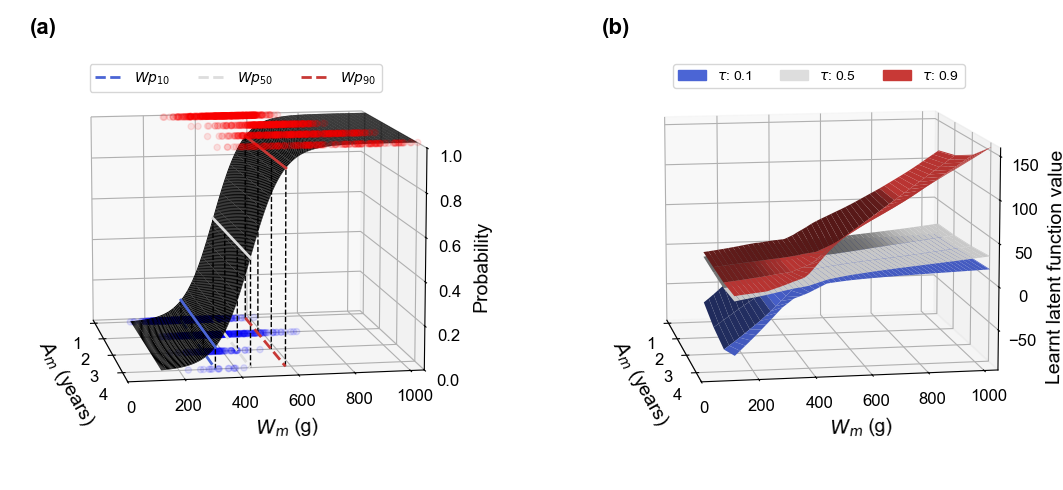

In [12]:
from matplotlib.patches import Patch

fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0], projection='3d', computed_zorder=False)  # 3D subplots
ax2 = fig.add_subplot(gs[1], projection='3d', computed_zorder=False)

## 2d PMRNS
q_vis = [1, 9, 17]  # probabilistic and quantile indices for visualization
X = df[['newage', 'total_w',]]
y = df['mat']

# Train logistic MM
logistic_model = LogisticRegression()  
logistic_model.fit(X, y)

# Extract model coefficients
alpha = logistic_model.intercept_[0]
beta = logistic_model.coef_[0][0]
gamma = logistic_model.coef_[0][1]

ages = np.unique(df['newage'])
# Function to calculate WP (Weight at probability) for given probability and age
def calculate_wp(prob, age):
    return -(alpha + beta * age + np.log((1 - prob) / prob)) / gamma

# Calculate WP values for selected [0.1, 0.5, 0.9] quantiles
quantiles = [0.1, 0.5, 0.9]
wp_values = {q: calculate_wp(q, ages) for q in quantiles}

# Create grid for surface plot
weight_range = np.linspace(df['total_w'].min(), df['total_w'].max(), 100)
age_range = np.linspace(df['newage'].min(), df['newage'].max(), 100)
weight_grid, age_grid = np.meshgrid(weight_range, age_range)
X_grid = np.column_stack([age_grid.ravel(), weight_grid.ravel()])

# Predict probabilities across grid
prob_grid = logistic_model.predict_proba(X_grid)[:, 1].reshape(weight_grid.shape)

df_immat = df[df.mat==0]  # Immature
df_mat = df[df.mat==1]  # Mature

# Scatter plot for immature (blue) and mature (red) individuals
scatter = ax1.scatter(df_immat['newage'], df_immat['total_w'], df_immat['mat'], c='blue', marker='o', s=20, alpha=0.1, zorder=10)
scatter = ax1.scatter(df_mat ['newage'], df_mat ['total_w'], df_mat ['mat'], c='red', marker='o', s=20, alpha=0.1, zorder=30)

# Plot probability surface
ax1.plot_surface(age_grid, weight_grid, prob_grid, color='k', zorder=20)

# Plot quantile lines and connections
for idx, q in enumerate(quantiles):
    wp_values_q = wp_values[q]
    # Bottom plane lines (z=0)
    ax1.plot(ages, wp_values_q, np.zeros_like(ages), color=colors[q_vis[idx]], linestyle='--', lw=2, zorder=18, label=r'$Wp_{%d}$' % int(q*100))
    # Probability plane lines (z=q)
    ax1.plot(ages, wp_values_q, q*np.ones_like(ages), color=colors[q_vis[idx]], lw=2, zorder=25)

    # Vertical dashed connections between planes
    for a, lp in zip(ages, wp_values_q):
        ax1.plot([a, a], [lp, lp], [0, q], color='k', linestyle='--', lw=1, zorder=15)

# Axis limits and labels for 2D PMRNs
ax1.set_xlim(0.8, 4.5)
ax1.set_ylim(0, 1050)
ax1.set_zlim(0, 1)
ax1.set_xlabel(r'$A_{m}$ (years)', fontsize=14, labelpad=6)
ax1.set_ylabel(r'$W_{m}$ (g)', fontsize=14, labelpad=10)
ax1.set_zlabel('Probability', fontsize=14, labelpad=6)
ax1.set_xticks([1, 2, 3, 4])
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.tick_params(axis='z', labelsize=12)
ax1.legend(loc='upper center', bbox_to_anchor=(0.48, 0.9), ncol=3)
ax1.set_box_aspect(None, zoom=0.95)
ax1.view_init(elev=10, azim=-10)

## 2D Quantile Maturation Reaction Norms (QMRNs) Visualization
attribute_array_1_, attribute_array_2_, outputs = BQR(f"./Data/data_simulated.csv",
                                                      batch_is=64,
                                                      x_cols=[0, 1],
                                                      y_col=2,
                                                      attribute_index=[0, 1],
                                                      attribute_name="newage",
                                                      latent_name="Maturity",
                                                      total_epochs=20,
                                                      ndim=2)

# Create grid for QMRN surface plots
X, Y = np.meshgrid(attribute_array_1_, attribute_array_2_)

quantiles_idx = [0, 4, 8]  # Indices for 0.1, 0.5, 0.9 quantiles
for idx, i in enumerate(quantiles_idx):
    ax2.plot_surface(X, Y, outputs[i, :, :], color=colors[q_vis[idx]])

# Create legend elements for quantiles
legend_elements = [Patch(facecolor=colors[q_vis[0]], edgecolor=colors[q_vis[0]], label=r"$\tau$: "+"0.1"),
                   Patch(facecolor=colors[q_vis[1]], edgecolor=colors[q_vis[1]], label=r"$\tau$: "+"0.5"),
                   Patch(facecolor=colors[q_vis[2]], edgecolor=colors[q_vis[2]], label=r"$\tau$: "+"0.9")]

# Axis limits and labels for 2D QMRNs
ax2.set_xlim(0.8, 4.5)
ax2.set_ylim(0, 1050)
ax2.set_xlabel(r'$A_{m}$ (years)', fontsize=14, labelpad=6)
ax2.set_ylabel(r'$W_{m}$ (g)', fontsize=14, labelpad=10)
ax2.set_zlabel('Learnt latent function value', fontsize=14, labelpad=6)
ax2.set_xticks([1, 2, 3, 4])
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='z', labelsize=12)
ax2.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.9), ncol=3)
ax2.set_box_aspect(None, zoom=0.95)
ax2.view_init(elev=10, azim=-10)

##########################################################################################################

# Add subplot labels
Alphbeta = ['a', 'b']
for i, ax_ in enumerate([ax1, ax2]):
    ax_.text2D(float(0.1), float(0.95), '('+ Alphbeta[i]+')', transform=ax_.transAxes, ha='right',
               fontsize=16, fontweight='bold')

# Save figures
plt.tight_layout()
plt.savefig("./Figs/Figure_S2.pdf")
plt.savefig("./Figs/Figure_S2.png", format="png", dpi=600, bbox_inches="tight")